In [1]:
using FFTW, LinearAlgebra, EllipsisNotation, FunctionOperators, PaddedViews, Base.Cartesian
using MacroTools, BenchmarkTools, ProgressMeter, Distributed, Random
include("jim.jl");

In [2]:
include("SigJl.jl")

Main.SigJl

In [3]:
using PyCall, Libdl
Libdl.dlopen(ENV["HOME"]*"/.local/lib/python3.6/site-packages/llvmlite/binding/libllvmlite.so",
    Libdl.RTLD_DEEPBIND);

In [4]:
np = pyimport("numpy")

sp = pyimport("sigpy")
mr = pyimport("sigpy.mri")
pl = pyimport("sigpy.plot")

pushfirst!(PyVector(pyimport("sys")."path"), "")
dd = pyimport("python.download_dataset")
gr = pyimport("python.gridding_recon")
reconImage = pyimport("python.multi_scale_low_rank_image")
recon = pyimport("python.multi_scale_low_rank_recon")

device = 0;

In [5]:
dd.download_dce_dataset()

ksp = np.load("data/dce/ksp.npy")
coord = np.load("data/dce/coord.npy")
dcf = np.load("data/dce/dcf.npy");

In [6]:
num_ro = 200  # number of readout points
ksp_py = ksp[:, :, 1:num_ro]
ksp_j = permutedims(ksp_py, (1, 3, 2))
coord_py = coord[:, 1:num_ro, :]
coord_j = permutedims(coord_py, (3, 2, 1))
dcf_py = dcf[:, 1:num_ro]
dcf_j = permutedims(dcf_py, (2, 1))
ksp, coord, dcf = fill(nothing, 3);

In [7]:
FFTW.set_num_threads(40)

In [8]:
SigJl.estimate_shape(coord_j)

3-element Array{Int64,1}:
  54
  69
 157

In [9]:
""" Gridding reconstruction.

Args:
    ksp (array): k-space measurements of shape (C, num_tr, num_ro), where
        C is the number of channels,
        num_tr is the number of TRs, and
        num_ro is the readout points.
    coord (array): k-space coordinates of shape (num_tr, num_ro, D), where
        D is the number of spatial dimensions.
    dcf (array): density compensation factor of shape (num_tr, num_ro).
    T (int): number of frames.

Returns:
    img (array): image of shape (T, N_D, ..., N_1).
"""
function gridding_recon(ksp, coord, dcf, T=1)
    # calculate size parameters
    C, num_ro, num_tr = size(ksp)
    D = size(coord, 1)
    tr_per_frame = num_tr ÷ T
    points_per_frame = tr_per_frame * num_ro
    
    # reshape arrays for batch processing
    ksp = reshape(ksp, C, T, points_per_frame)
    coord = reshape(coord, D, T, points_per_frame)
    dcf = reshape(dcf, 1, T, points_per_frame)
    
    # Here happens the "magic"
    img = abs2.(SigJl.nufft_adjoint(coord, ksp .* dcf, threaded=true))
            #progressTitle="Gridding reconstruction", progress_dt=0.2))
    
    # sum along coils and take square root
    return sqrt.(sum(img, dims=1))
end

gridding_recon

In [11]:
@time grd_julia = gridding_recon(ksp_j, coord_j, dcf_j);

  7.569660 seconds (8.37 M allocations: 5.322 GiB, 40.02% gc time)


In [13]:
@time grd_python = gr.gridding_recon(ksp_py, coord_py, dcf_py, device=0);

  2.092802 seconds (79 allocations: 2.236 MiB)


In [14]:
print("absolute error: ", norm(grd_julia - grd_python, Inf), "\n",
    "relative error: ", norm((grd_julia - grd_python) ./ grd_python, Inf))

absolute error: 2.330239e-5
relative error: 0.021174354

In [41]:
function visualize(img; slice)
    if ndims(img) == 4
        jim(permutedims(img[:,slice,end:-1:1,end:-1:1], (3,2,1)), abswarn=false)
    else
        jim(permutedims(img[slice,end:-1:1,end:-1:1], (2,1)), abswarn=false)
    end
end

visualize (generic function with 1 method)

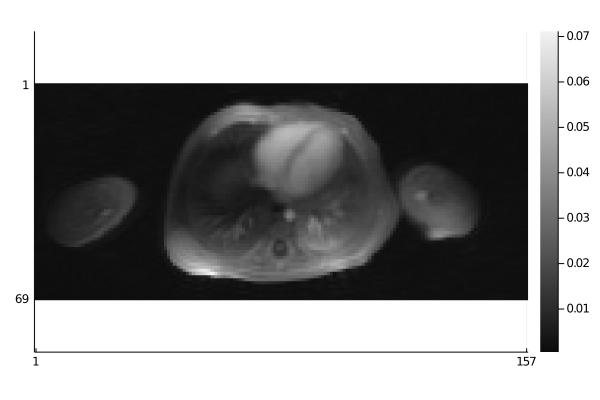

In [16]:
visualize(grd_julia, slice=27)

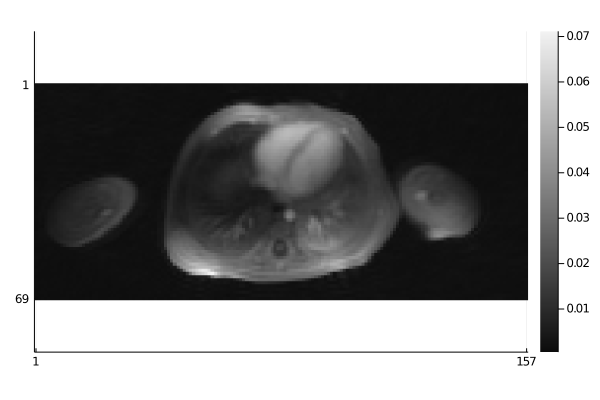

In [17]:
visualize(grd_python, slice=27)

In [15]:
#mps = np.load("data/dce/mps.npy");
@time mps = mr.app.JsenseRecon(ksp_py, coord=coord_py, weights=dcf_py, device=device).run();
np.save("data/dce/mps_200.npy", mps)

162.267389 seconds (777.65 k allocations: 93.062 MiB)


JsenseRecon: 100%|█████████████████████████████| 10/10 [02:40<00:00, 16.04s/it]

In [16]:
visualize(mps, slice=27)

UndefVarError: UndefVarError: visualize not defined

In [17]:
T = 100
lambda = 1e-8
block_widths = [8, 16, 32]  # For low resolution.

3-element Array{Int64,1}:
  8
 16
 32

In [21]:
@time img_py = recon.MultiScaleLowRankRecon(ksp_py, coord_py, dcf_py, mps, T, lambda, max_power_iter=3,
    max_epoch=3, device=device, blk_widths=block_widths, show_pbar=false).run();

186.273632 seconds (888.65 k allocations: 43.793 MiB)


In [22]:
img_py.use_device(device)

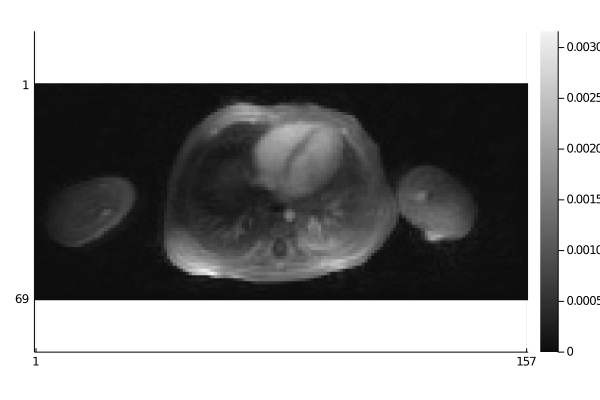

In [23]:
visualize(img_py.__getitem__(80), slice=27)

In [18]:
@generated function blocks_to_array!(
        output::AbstractArray{T, D},
        input::AbstractArray{T, D2},
        block_shape::NTuple{D, Int},
        shifts::NTuple{D, Int}) where {T, D, D2}
    @assert 2*D == D2 "Dimension mismatch! Proper dimensionality: 2*ndims(output) = ndims(input)"
    quote
        @nloops($D, block_idx, input, begin
                @nloops($D, point_idx, d -> axes(input, $D + d),
                    d -> begin
                        pos_in_output_d = (block_idx_d - 1) * shifts[d] + point_idx_d
                        pos_in_output_d > size(output, d) && break
                    end,
                    @inbounds @nref($D, output, pos_in_output) +=
                        input[@ntuple($D, block_idx)..., @ntuple($D, point_idx)...])
            end)
        return output
    end
end

blocks_to_array! (generic function with 1 method)

In [19]:
@generated function array_to_blocks!(
        output::AbstractArray{T, D2},
        input::AbstractArray{T, D},
        block_shape::NTuple{D, Int},
        shifts::NTuple{D, Int}) where {T, D, D2}
    @assert 2*D == D2 "Dimension mismatch! Proper dimensionality: ndims(output) = 2*ndims(input)"
    quote
        @nloops($D, block_idx, output, begin
                @nloops($D, point_idx, d -> axes(output, $D + d),
                    d -> pos_in_output_d = (block_idx_d - 1) * shifts[d] + point_idx_d,
                    @inbounds output[@ntuple($D, block_idx)..., @ntuple($D, point_idx)...] = 
                        @nany($D, d -> pos_in_output_d > size(input, d)) ?
                            zero($T) :
                            @nref($D, input, pos_in_output))
            end)
        return output
    end
end

array_to_blocks! (generic function with 1 method)

In [20]:
function hanning(shape)
    shape = shape isa Number ? (shape,) : shape
    hanningFunction(x, width) = 0.5 - 0.5 * cos(2π * x / max(1, (width - (width % 2))))
    multiDimHanning(coord) = prod([hanningFunction(coord[i]-1, shape[i]) for i in 1:length(shape)])
    [multiDimHanning(coord) for coord in CartesianIndices(tuple(UnitRange.(1, shape)...))]
end

hanning (generic function with 1 method)

In [21]:
# Some fancy stuff for naming
#   e.g. the array-to-block operator for the scale with block-size 8 as "𝓑₈"
digitToSubscript(d) = string(Char(Int('₀')+d))
numberToSubscript(n) = join([digitToSubscript(Int(d)-48) for d in string(n)])

numberToSubscript (generic function with 1 method)

In [22]:
function _get_ℳ(block_width, img_shape, dtype)
    
    block_shape = min.(img_shape, block_width)
    shifts = (block_shape .+ 1) .÷ 2
    num_blocks = ceil.(Int, img_shape ./ shifts .- 1)
    ndim = length(num_blocks)
    
    # Blocking operator:
    #  - forward embeds blocks in the output image in a sliding window manner
    #  - backward rearranges the image to blocks
    𝓑 = FunctionOperator{dtype}(name = "𝓑"*numberToSubscript(block_width),
        forw = (b, x) -> begin
            b .= zero(dtype)
            blocks_to_array!(b, x, block_shape, shifts)
        end,
        backw = (b, x) -> array_to_blocks!(b, x, block_shape, shifts),
        inDims = (num_blocks..., block_shape...),
        outDims = img_shape)
    
    # Multiplication with Hanning window to cancel the effect of sliding window.
    # Blocks are multiplied with the squre root of the window before and after the blocking operator.
    HanningWindow = reshape(sqrt.(hanning(block_shape)), fill(1, ndim)..., block_shape...)
    𝓦 = FunctionOperator{dtype}(name = "𝓦"*numberToSubscript(block_width),
        forw = (b, x) -> b .= x .* HanningWindow,
        backw = (b, x) -> b .= x .* HanningWindow,
        inDims = (num_blocks..., block_shape...),
        outDims = (num_blocks..., block_shape...))
    
    return 𝓑 * 𝓦
end

_get_ℳ (generic function with 1 method)

In [23]:
function _get_𝒩(t, coordₜ, mps, frame_coils, img_shape, C, num_ro, tr_per_frame, dtype)
    plan = SigJl.nufft_plan(coordₜ[t], (C, img_shape...))
    plan_adjoint = plan'
    FunctionOperator{dtype}(name = "𝒩"*numberToSubscript(t),
        forw = (kspₜ, frameₜ) -> begin
                frame_coils[Threads.threadid()] .= reshape(frameₜ, 1, size(frameₜ)...) .* mps
                mul!(kspₜ, plan, frame_coils[Threads.threadid()])
            end,
        backw = (frameₜ, kspₜ) -> begin
                mul!(frame_coils[Threads.threadid()], plan_adjoint, kspₜ)
                frame_coils[Threads.threadid()] .*= conj.(mps)
                sum!(reshape(frameₜ, 1, size(frameₜ)...), frame_coils[Threads.threadid()])
                frameₜ
            end,
        inDims = img_shape,
        outDims = (C, num_ro, tr_per_frame))
end

_get_𝒩 (generic function with 1 method)

In [24]:
function _get_𝒟²(t, dcfₜ, C, num_ro, tr_per_frame, dtype)
    FunctionOperator{dtype}(name = "𝒟²"*numberToSubscript(t),
        forw = (outputₜ, inputₜ) -> error("Not implemented"),
        backw = (outputₜ, inputₜ) -> begin
                outputₜ .= inputₜ .* dcfₜ[t]
            end,
        inDims = (C, num_ro, tr_per_frame),
        outDims = (C, num_ro, tr_per_frame))
end

_get_𝒟² (generic function with 1 method)

In [25]:
function _get_𝒟(t, dcfₜ, C, num_ro, tr_per_frame, dtype)
    FunctionOperator{dtype}(name = "𝒟"*numberToSubscript(t),
        forw = (outputₜ, inputₜ) -> begin
                outputₜ .= inputₜ .* sqrt.(dcfₜ[t])
            end,
        backw = (outputₜ, inputₜ) -> begin
                outputₜ .= inputₜ .* sqrt.(dcfₜ[t])
            end,
        inDims = (C, num_ro, tr_per_frame),
        outDims = (C, num_ro, tr_per_frame))
end

_get_𝒟 (generic function with 1 method)

In [26]:
function _get_λ(block_width, λ, img_shape, T, dtype)
    
    block_shape = min.(img_shape, block_width)
    shifts = (block_shape .+ 1) .÷ 2
    num_blocks = ceil.(Int, img_shape ./ shifts .- 1)
    
    N = prod(block_shape)
    B = prod(num_blocks)
    
    return λ * (√N + √T + √(2log(B)))
end

_get_λ (generic function with 1 method)

In [27]:
function MaxEig!(op, x, iter_num)
    λₘₐₓ = Inf
    #@showprogress 0.2 "Normalization of dcf... "
    for i in 1:iter_num
        mul!(x, op, x)
        λₘₐₓ = norm(x, 2)
        x ./= λₘₐₓ
    end
    λₘₐₓ
end

MaxEig! (generic function with 1 method)

In [28]:
function _normalize(coord, dcf, ksp, mps, img_shape, C, T, tr_per_frame, max_power_iter, dtype)
    
    # Estimate maximum eigenvalue.
    print("Normalization of dcf:\t\t\t")
    @time begin
        coordₜ₁ = @view coord[:, :, 1:tr_per_frame]
        dcfₜ₁ = reshape(@view(dcf[:, 1:tr_per_frame]), 1, :, tr_per_frame)
        plan = SigJl.nufft_plan(coordₜ₁, img_shape, threaded = true)
        adj_plan = plan'
        𝒩ₜ₁ = FunctionOperator{dtype}(name = "𝒩ₜ₁",
            forw = (b, x) -> mul!(b, plan, x),
            backw = (b, x) -> mul!(b, adj_plan, x),
            inDims = img_shape,
            outDims = size(coordₜ₁))
        𝒟²ₜ₁ = FunctionOperator{dtype}(name = "𝒟ₜ₁",
            forw = (b, x) -> b .= x .* dcfₜ₁,
            inDims = size(coordₜ₁),
            outDims = size(coordₜ₁))
        x₀ = convert.(eltype(ksp), rand(img_shape...))
        λₘₐₓ = MaxEig!(𝒩ₜ₁' * 𝒟²ₜ₁ * 𝒩ₜ₁, x₀, max_power_iter)
        dcf ./= abs(λₘₐₓ)
    end
    
    # Estimate scaling
    print("Normalization of ksp:\t\t\t")
    @time begin
        dcf = reshape(dcf, 1, size(dcf)...)
        img = SigJl.nufft_adjoint(coord, ksp .* dcf, oshape=(C, img_shape...), threaded=true)
                #progressTitle="Normalization of ksp... ", progress_dt=0.2)
        img .*= conj.(mps)
        ksp ./= norm(sum(img, dims=1), 2)
    end
    
    dcf, ksp
end

_normalize (generic function with 1 method)

In [29]:
function normalize_L!(L)
    D = ndims(L) ÷ 2
    L_norm = mapslices(norm, L, dims=D+1:2D)
    L ./= L_norm
    L_norm
end

normalize_L! (generic function with 1 method)

In [30]:
function normalize_R!(Rₜ)
    R = parent(Rₜ[1])
    R ./= mapslices(norm, R, dims=ndims(R))
end

normalize_R! (generic function with 1 method)

In [31]:
function _init_L(blocked_shape, dtype)
    L = randn(dtype, blocked_shape)
    normalize_L!(L)
    L
end

_init_L (generic function with 1 method)

In [32]:
function _init_R(blocked_shape, D, T, dtype)
    Array{dtype}(undef, (blocked_shape[1:D]..., fill(1, D)..., T))
end

_init_R (generic function with 1 method)

In [33]:
function powerIter_R!(Rⱼₜ, Aᴴy, AᴴyLᴴⱼ, t, 𝒜, ℳⱼ, kspₜ, Lⱼ)
    mul!(Aᴴy, 𝒜', kspₜ[t])
    for j in 1:length(Rⱼₜ)
        mul!(AᴴyLᴴⱼ[j], ℳⱼ[j]', Aᴴy)
        AᴴyLᴴⱼ[j] .*= conj.(Lⱼ[j])
        sum!(Rⱼₜ[j][t], AᴴyLᴴⱼ[j])
    end
end

powerIter_R! (generic function with 1 method)

In [34]:
function powerIter_L!(Lⱼ, Aᴴy, t, 𝒜, ℳⱼ, kspₜ, Rⱼₜ)
    mul!(Aᴴy, 𝒜', kspₜ[t])
    for j in 1:length(Lⱼ)
        Lⱼ[j] .+= (ℳⱼ[j]' * Aᴴy) .* conj.(Rⱼₜ[j][t])
    end
end

powerIter_L! (generic function with 1 method)

In [35]:
function _power_method!(Lⱼ, Rⱼₜ, 𝒩ₜ, 𝒟²ₜ, ℳⱼ, kspₜ, dcfₜ, img_shape, D, max_power_iter, dtype)
    
    σⱼ = nothing
    J = length(Lⱼ)
    
    # We need these only to avoid re-allocation of same buffers over and over again
    Lⱼ_buffers = [deepcopy(Lⱼ) for _ in 1:Threads.nthreads()]
    Aᴴy_buffers = [similar(kspₜ[1], img_shape) for _ in 1:Threads.nthreads()]
    
    for it in 1:max_power_iter
        # Rⱼₜ = calc_norm_of_blocks(ℳⱼᴴ(Aₜᴴ⋅yₜᴴ)⋅Lⱼᴴ)
        p = Progress(T+1, 0.2, "Power iteration (R, $it/$max_power_iter)... ")
        @time begin
            Threads.@threads for t in 1:T
                Aᴴy_buffer = Aᴴy_buffers[Threads.threadid()]
                AᴴyLⱼᴴ_buffer = Lⱼ_buffers[Threads.threadid()]
                powerIter_R!(Rⱼₜ, Aᴴy_buffer, AᴴyLⱼᴴ_buffer, t, 𝒟²ₜ[t] * 𝒩ₜ(t), ℳⱼ, kspₜ, Lⱼ)
                next!(p)
            end
            pmap(normalize_R!, Rⱼₜ)
            finish!(p)
        end
        
        # Lⱼ = Σₜ(ℳⱼᴴ(Aₜᴴ⋅yₜᴴ)⋅Rⱼₜᴴ)
        p = Progress(T+3, 0.2, "Power iteration (L, $it/$max_power_iter)... ")
        @time begin
            Threads.@threads for i in 1:Threads.nthreads()
                fill!.(Lⱼ_buffers[i], zero(dtype))
            end
            next!(p)
            Threads.@threads for t in 1:T
                Aᴴy_buffer = Aᴴy_buffers[Threads.threadid()]
                Lⱼ_buffer = Lⱼ_buffers[Threads.threadid()]
                powerIter_L!(Lⱼ_buffer, Aᴴy_buffer, t, 𝒟²ₜ[t] * 𝒩ₜ(t), ℳⱼ, kspₜ, Rⱼₜ)
                next!(p)
            end
            for i in 1:Threads.nthreads(), j in 1:J
                i == 1 ? Lⱼ[j] .= Lⱼ_buffers[i][j] : Lⱼ[j] .+= Lⱼ_buffers[i][j]
            end
            next!(p)
            
            σⱼ = pmap(normalize_L!, Lⱼ) # save the norm of L at each level
            finish!(p)
        end
        
    end

    for j in 1:J
        Lⱼ[j] .*= sqrt.(σⱼ[j])
        parent(Rⱼₜ[j][1]) .*= sqrt.(σⱼ[j])
    end
    
    σⱼ
end

_power_method! (generic function with 1 method)

In [36]:
function _sgd(𝒩ₜ, 𝒟ₜ, ℳⱼ, kspₜ, Lⱼ, Rⱼₜ, T, α, β, σⱼ, λⱼ, D, max_epoch, decay_epoch, img_shape, dtype)
    J = length(Rⱼₜ)
    for epoch in 1:max_epoch
        loss = 0
        p = Progress(T, 0.2, "Epoch {epoch}/{max_epoch}... ")
        N = 2 # batch size #Threads.nthreads()
        imgₙ = [similar(Rⱼₜ[1], dtype, img_shape) for n in 1:N]
        ∇Lₙⱼ = [[similar(Lⱼ[j]) for j in 1:J] for n in 1:N]
        ∇Rₙⱼ = [[similar(Rⱼₜ[j][1]) for j in 1:J] for n in 1:N]
        lossₙ = fill(zero(eltype(λⱼ[1])), N)
        for tₙ in Iterators.partition(randperm(T), N)
            Threads.@threads for n in 1:length(tₙ)
                ∇Lⱼ, ∇Rⱼ, t, img = ∇Lₙⱼ[n], ∇Rₙⱼ[n], tₙ[n], imgₙ[n]
                lossₙ[n] = _step!(∇Lⱼ, ∇Rⱼ, t, 𝒩ₜ, 𝒟ₜ, ℳⱼ, img, kspₜ, img_shape,
                                    Lⱼ, Rⱼₜ, σⱼ, λⱼ, D, dtype)
                next!(p)
            end
            loss += sum(lossₙ[1:length(tₙ)])
            ∇Lⱼ = ∇Lₙⱼ[1]; [∇Lⱼ .+= ∇Lₙⱼ[n] for n in 2:length(tₙ)]
            for j in 1:J
                Lⱼ[j] .-= α .* β^(epoch ÷ decay_epoch) .* ∇Lⱼ[j]
                [Rⱼₜ[j][tₙ[n]] .-= α .* ∇Rₙⱼ[n][j] for n in 1:length(tₙ)]
            end
        end
    end
end

_sgd (generic function with 1 method)

In [37]:
function _step!(∇Lⱼ, ∇Rⱼ, t, 𝒩ₜ, 𝒟ₜ, ℳⱼ, img, kspₜ, img_shape, Lⱼ, Rⱼₜ, σⱼ, λⱼ, D, dtype)
    J = length(Rⱼₜ)
    # Form image.
    fill!(img, zero(dtype))
    [img .+= ℳⱼ[j] * (Lⱼ[j] .* Rⱼₜ[j][t]) for j in 1:J]

    # Data consistency.
    𝒩, 𝒟 = 𝒩ₜ(t), 𝒟ₜ[t]
    ksp_hat = 𝒩 * img
    diff_hat = ksp_hat .-= kspₜ[t]
    mul!(diff_hat, 𝒟, diff_hat)
    loss = 0.5 * norm(diff_hat)^2
    diff = mul!(img, 𝒩' * 𝒟', diff_hat)

    # Compute gradient.
    for j in 1:J

        # Loss.
        loss += λⱼ[j] / 2 * (norm(Lⱼ[j])^2 / T + norm(Rⱼₜ[j][t])^2)
        np.isnan(loss) && error("loss is NaN")
        (isinf(loss)) && throw(OverflowError("loss overflow"))

        # L gradient.
        diff_blocks = ℳⱼ[j]' * diff
        @. ∇Lⱼ[j] = T * (diff_blocks * conj(Rⱼₜ[j][t]) + λⱼ[j] / T * Lⱼ[j])

        # R gradient.
        sum!(∇Rⱼ[j], diff_blocks .*= conj.(Lⱼ[j]))
        ∇Rⱼ[j] .+= λⱼ[j] .* Rⱼₜ[j][t]

        # Precondition.
        ∇Lⱼ[j] ./= J .* σⱼ[j] .+ λⱼ[j]
        ∇Rⱼ[j] ./= J .* σⱼ[j] .+ λⱼ[j]

    end

    return loss
end

_step! (generic function with 1 method)

In [38]:
function MultiScaleLowRankRecon(
        ksp, coord, dcf, mps, T, λ;
        block_widths=[32, 64, 128], α=1, β=0.5, sgw=nothing,
        seed=0, max_epoch=60, decay_epoch=20, max_power_iter=5)
    
    ## --- Initialization --- ##
    println(" ---- Initialization ----")
    dtype = eltype(ksp)
    C, num_ro, num_tr = size(ksp)
    tr_per_frame = num_tr ÷ T
    img_shape = size(mps)[2:end]
    D = length(img_shape)
    J = length(block_widths)
    
    Random.seed!(seed)
    
    !(sgw isa Nothing) && (dcf .*= resize(sgw, size(sgw)..., 1))
    dcf, ksp = _normalize(coord, copy(dcf), copy(ksp), mps,
                    img_shape, C, T, tr_per_frame, max_power_iter, dtype)
    
    print("initialization:\t\t\t\t")
    @time begin
        get_frame_range(t) = ((t - 1) * tr_per_frame + 1):(t * tr_per_frame)
        # create views to access time frames more easily
        coordₜ = [@view coord[:,:,get_frame_range(t)] for t in 1:T]
        kspₜ = [@view ksp[:,:,get_frame_range(t)] for t in 1:T]
        dcfₜ = [@view dcf[:,:,get_frame_range(t)] for t in 1:T]
        # Regularization parameters for each levels
        λⱼ = [_get_λ(bw, λ, img_shape, T, dtype) for bw in block_widths]
        # buffers for each thread to store intermediate results of shape (C, img_shape...)
        frame_coils = [similar(mps) for _ in 1:Threads.nthreads()]
        # Blocking operators (image array ⟷ blocks)
        ℳⱼ = [_get_ℳ(bw, img_shape, dtype) for bw in block_widths]
        # NUFFT operators (lazily created to save memory)
        𝒩ₜ = t -> _get_𝒩(t, coordₜ, mps, frame_coils, img_shape, C, num_ro, tr_per_frame, dtype)
        # Density compensation operators
        𝒟²ₜ = [_get_𝒟²(t, dcfₜ, C, num_ro, tr_per_frame, dtype) for t in 1:T]
        # Initialize L and R vectors
        Lⱼ_init = [_init_L(ℳⱼ[j].inDims, dtype) for j in 1:J]
        Rⱼ_init = [_init_R(ℳⱼ[j].inDims, D, T, dtype) for j in 1:J]
        Rⱼₜ_init = [[@view(Rⱼ_init[j][.., t]) for t in 1:T] for j in 1:J]
    end
    
    σⱼ = _power_method!(Lⱼ_init, Rⱼₜ_init, 𝒩ₜ, 𝒟²ₜ, ℳⱼ, kspₜ, dcfₜ, img_shape, D, max_power_iter, dtype)
    
    println(" ---- Reconstruction ----")
    𝒟ₜ = [_get_𝒟(t, dcfₜ, C, num_ro, tr_per_frame, dtype) for t in 1:T]
    done = false
    while !done
        Lⱼ, Rⱼₜ = deepcopy(Lⱼ_init), deepcopy(Rⱼₜ_init)
        try
            _sgd(𝒩ₜ, 𝒟ₜ, ℳⱼ, kspₜ, Lⱼ, Rⱼₜ, T, α, β, σⱼ, λⱼ, D, max_epoch, decay_epoch, img_shape, dtype)
            done = true
        catch err
            if err isa OverflowError && err.msg == "loss overflow"
                α *= β
                println("Reconstruction diverged. New step size: $α")
                if α < 1e-4
                    error("too small α value, reconstruction seems not to converge...")
                end
            else
                rethrow(err)
            end
        end
    end
    return ℳⱼ, Lⱼ_init, Rⱼₜ_init
end

MultiScaleLowRankRecon (generic function with 1 method)

In [39]:
@time ℳⱼ, Lⱼ, Rⱼ = MultiScaleLowRankRecon(ksp_j, coord_j, dcf_j, mps, T, lambda,
    max_power_iter=3, max_epoch=3, block_widths=block_widths);

 ---- Initialization ----
Normalization of dcf:			  4.781116 seconds (9.26 M allocations: 814.167 MiB)
Normalization of ksp:			  9.476674 seconds (9.39 M allocations: 5.344 GiB, 44.79% gc time)
initialization:				  7.758882 seconds (9.60 M allocations: 2.656 GiB, 49.21% gc time)


Power iteration (R, 1/3)... 100%|███████████████████████| Time: 0:00:16


 16.976984 seconds (15.86 M allocations: 22.164 GiB, 2.57% gc time)


Power iteration (L, 1/3)... 100%|███████████████████████| Time: 0:00:26


 26.398775 seconds (10.78 M allocations: 30.631 GiB, 35.07% gc time)


Power iteration (R, 2/3)... 100%|███████████████████████| Time: 0:00:23


 23.322025 seconds (8.58 M allocations: 21.820 GiB, 39.60% gc time)


Power iteration (L, 2/3)... 100%|███████████████████████| Time: 0:00:27


 27.234926 seconds (8.63 M allocations: 30.530 GiB, 38.35% gc time)


Power iteration (R, 3/3)... 100%|███████████████████████| Time: 0:00:24


 24.697424 seconds (8.58 M allocations: 21.820 GiB, 41.34% gc time)


Power iteration (L, 3/3)... 100%|███████████████████████| Time: 0:00:25


 25.935332 seconds (8.63 M allocations: 30.530 GiB, 36.34% gc time)
 ---- Reconstruction ----


Epoch {epoch}/{max_epoch}... 100%|██████████████████████| Time: 0:02:25
Epoch {epoch}/{max_epoch}... 100%|██████████████████████| Time: 0:02:18
Epoch {epoch}/{max_epoch}... 100%|██████████████████████| Time: 0:02:16


595.791561 seconds (161.58 M allocations: 309.844 GiB, 23.63% gc time)


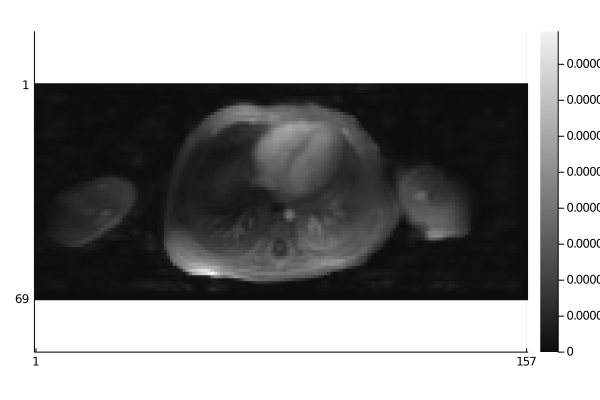

In [42]:
visualize(ℳⱼ[1] * (Lⱼ[1] .* Rⱼ[1][.., 80]), slice=27)

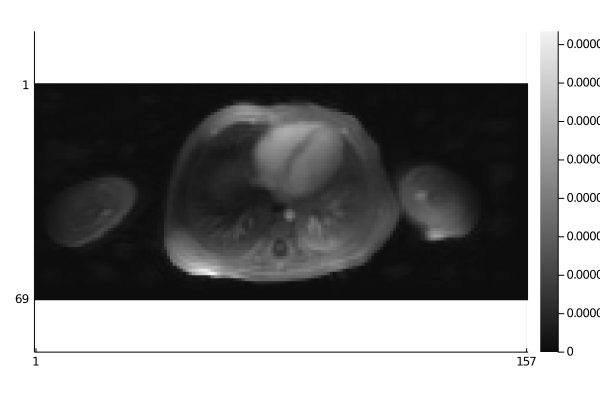

In [43]:
visualize(ℳⱼ[2] * (Lⱼ[2] .* Rⱼ[2][.., 80]), slice=27)

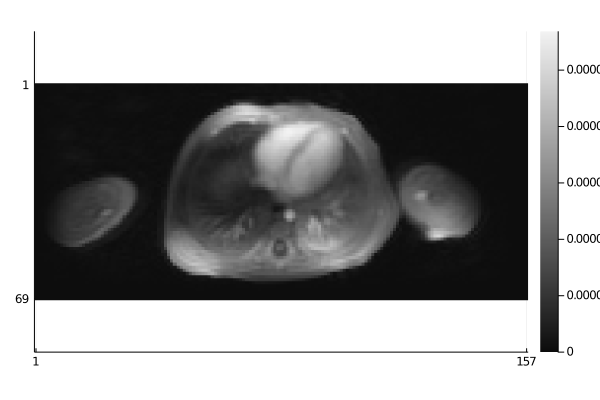

In [44]:
visualize(ℳⱼ[3] * (Lⱼ[3] .* Rⱼ[3][.., 80]), slice=27)

In [ ]:
@time ℳⱼ, Lⱼ, Rⱼ = MultiScaleLowRankRecon(ksp_j, coord_j, dcf_j, mps, T, lambda,
    max_power_iter=3, max_epoch=3, block_widths=block_widths);

 ---- Initialization ----
Normalization of dcf:			  4.886872 seconds (9.25 M allocations: 813.281 MiB)
Normalization of ksp:			 10.656580 seconds (9.39 M allocations: 5.344 GiB, 50.47% gc time)
initialization:				  8.838125 seconds (9.23 M allocations: 2.639 GiB, 54.55% gc time)


Power iteration (R, 1/3)... 100%|███████████████████████| Time: 0:00:17


 17.553440 seconds (15.80 M allocations: 22.160 GiB, 4.44% gc time)


Power iteration (L, 1/3)... 100%|███████████████████████| Time: 0:00:29


 29.650808 seconds (10.78 M allocations: 30.631 GiB, 39.46% gc time)


Power iteration (R, 2/3)... 100%|███████████████████████| Time: 0:00:24


 24.607968 seconds (8.58 M allocations: 21.820 GiB, 42.74% gc time)


Power iteration (L, 2/3)... 100%|███████████████████████| Time: 0:00:30


 30.391196 seconds (8.63 M allocations: 30.530 GiB, 45.06% gc time)


Power iteration (R, 3/3)... 100%|███████████████████████| Time: 0:00:25


 25.363808 seconds (8.58 M allocations: 21.820 GiB, 44.61% gc time)


Power iteration (L, 3/3)... 100%|███████████████████████| Time: 0:00:26


 26.681523 seconds (8.63 M allocations: 30.530 GiB, 39.36% gc time)
 ---- Reconstruction ----


Epoch {epoch}/{max_epoch}...   5%|█▏                    |  ETA: 0:03:55

In [ ]:
py"""
from math import ceil
import sigpy as sp
import numpy as np
"""

In [94]:
py"""
def _sgd(self):
    for self.epoch in range(self.max_epoch):
        total = self.T
        loss = 0
        for i, t in enumerate(range(self.T)): #np.random.permutation(self.T)):
            loss += _update(t)
"""

In [75]:
py"""
def _update(self, t):
    # Form image.
    img_t = 0
    for j in range(self.J):
        img_t += self.B[j](self.L[j] * self.R[j][t])

    # Download k-space arrays.
    tr_start = t * self.tr_per_frame
    tr_end = (t + 1) * self.tr_per_frame
    coord_t = sp.to_device(self.coord[tr_start:tr_end], self.device)
    dcf_t = sp.to_device(self.dcf[tr_start:tr_end], self.device)
    ksp_t = sp.to_device(self.ksp[:, tr_start:tr_end], self.device)

    # Data consistency.
    e_t = 0
    loss_t = 0
    for c in range(self.C):
        mps_c = sp.to_device(self.mps[c], self.device)
        e_tc = sp.nufft(img_t * mps_c, coord_t)
        e_tc -= ksp_t[c]
        e_tc *= dcf_t**0.5
        loss_t += self.xp.linalg.norm(e_tc)**2
        e_tc *= dcf_t**0.5
        e_tc = sp.nufft_adjoint(e_tc, coord_t, oshape=self.img_shape)
        e_tc *= self.xp.conj(mps_c)
        e_t += e_tc

    if self.comm is not None:
        self.comm.allreduce(e_t)
        self.comm.allreduce(loss_t)
    print(t, max(e_t), min(e_t)

    loss_t = loss_t.item()

    # Compute gradient.
    for j in range(self.J):
        lamda_j = self.lamda * self.G[j]

        # Loss.
        loss_t += lamda_j / self.T * self.xp.linalg.norm(self.L[j]).item()**2
        loss_t += lamda_j * self.xp.linalg.norm(self.R[j][t]).item()**2
        if np.isinf(loss_t) or np.isnan(loss_t):
            raise OverflowError

        # L gradient.
        g_L_j = self.B[j].H(e_t)
        g_L_j *= self.xp.conj(self.R[j][t])
        g_L_j += lamda_j / self.T * self.L[j]
        g_L_j *= self.T

        # R gradient.
        g_R_jt = self.B[j].H(e_t)
        g_R_jt *= self.xp.conj(self.L[j])
        g_R_jt = self.xp.sum(g_R_jt, axis=range(-self.D, 0), keepdims=True)
        g_R_jt += lamda_j * self.R[j][t]

        # Precondition.
        g_L_j /= self.J * self.sigma[j] + lamda_j
        g_R_jt /= self.J * self.sigma[j] + lamda_j

        # Add.
        self.L[j] -= self.alpha * self.beta**(self.epoch // self.decay_epoch) * g_L_j
        self.R[j][t] -= self.alpha * g_R_jt

    loss_t /= 2
    return loss_t
"""

In [ ]:
py"""
def run(self):
    with self.device:
        self._init_vars()
        self._power_method()
        self.L_init = []
        self.R_init = []
        for j in range(self.J):
            self.L_init.append(sp.to_device(self.L[j]))
            self.R_init.append(sp.to_device(self.R[j]))

        done = False
        while not done:
            try:
                self.L = []
                self.R = []
                for j in range(self.J):
                    self.L.append(sp.to_device(self.L_init[j], self.device))
                    self.R.append(sp.to_device(self.R_init[j], self.device))

                self._sgd()
                done = True
            except OverflowError:
                self.alpha *= self.beta
                if self.show_pbar:
                    tqdm.write('\nReconstruction diverged. '
                               'Scaling step-size by {}.'.format(self.beta))

        if self.comm is None or self.comm.rank == 0:
            return MultiScaleLowRankImage(
                (self.T, ) + self.img_shape,
                [sp.to_device(L_j, sp.cpu_device) for L_j in self.L],
                [sp.to_device(R_j, sp.cpu_device) for R_j in self.R])
"""

In [151]:
norm(ℳⱼ[1] * (Lⱼ[1] .* Rⱼ[1][.., 20]))

0.009365148f0

In [58]:
@time r = recon.MultiScaleLowRankRecon(ksp_py, coord_py, dcf_py, mps, T, lamda, max_epoch=1,
    max_power_iter=1, device=device, blk_widths=blk_widths, show_pbar=false)

  1.565400 seconds (175.13 k allocations: 9.039 MiB)


PyObject <python.multi_scale_low_rank_recon.MultiScaleLowRankRecon object at 0x7f759e254400>

In [59]:
r._init_vars()

In [60]:
@time r._power_method()

 11.802838 seconds (7 allocations: 320 bytes)


In [61]:
@time r.run()

 24.170243 seconds (7 allocations: 320 bytes)


PyObject <python.multi_scale_low_rank_image.MultiScaleLowRankImage object at 0x7f759e254eb8>

In [140]:
L_py = [sp.to_device(r.L[j], sp.cpu_device) for j in 1:3]
R_py = [sp.to_device(r.R[j], sp.cpu_device) for j in 1:3];

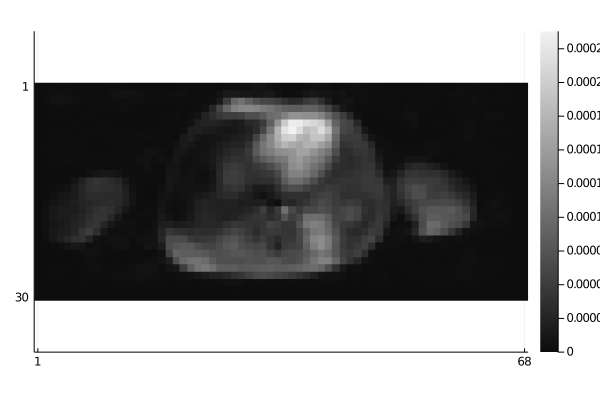

In [43]:
visualize(ℳⱼ[1] * (Lⱼ[1] .* Rⱼ[1][.., 20]), slice=16)

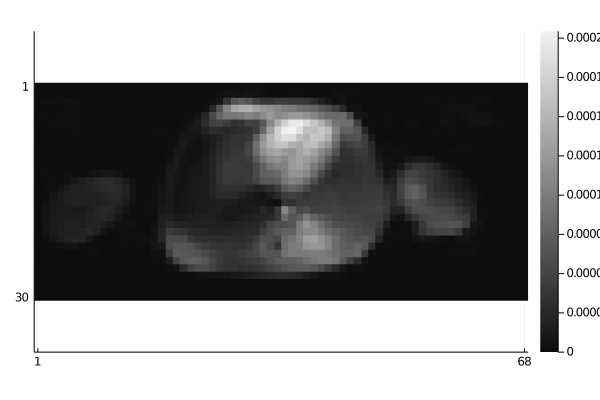

In [44]:
visualize(ℳⱼ[2] * (Lⱼ[2] .* Rⱼ[2][.., 20]), slice=16)

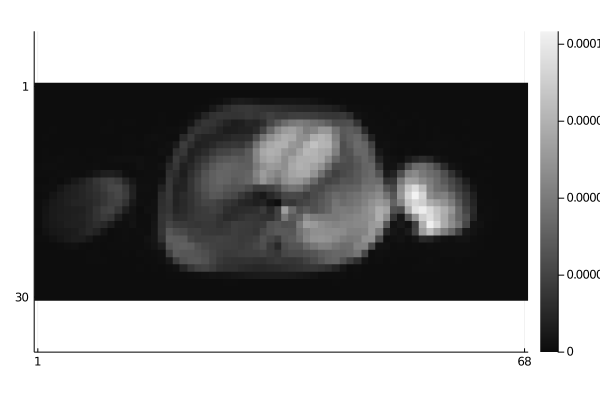

In [45]:
visualize(ℳⱼ[3] * (Lⱼ[3] .* Rⱼ[3][.., 20]), slice=16)

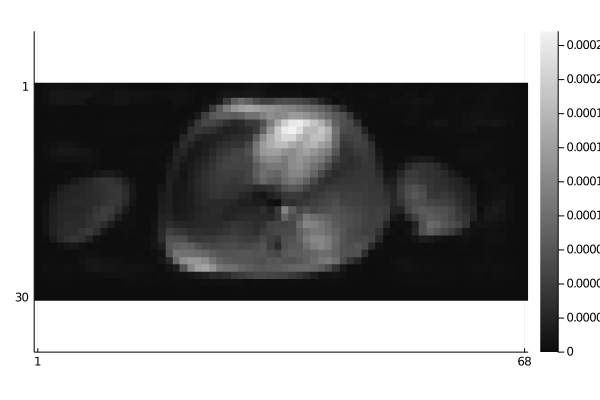

In [144]:
visualize(ℳⱼ[1] * (L_py[1] .* R_py[1][20, ..]), slice=16)

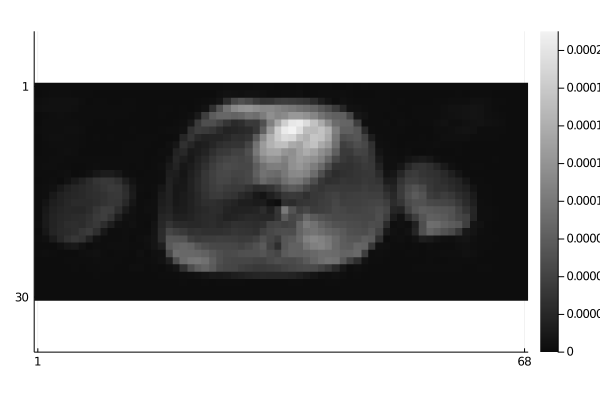

In [145]:
visualize(ℳⱼ[2] * (L_py[2] .* R_py[2][20, ..]), slice=16)

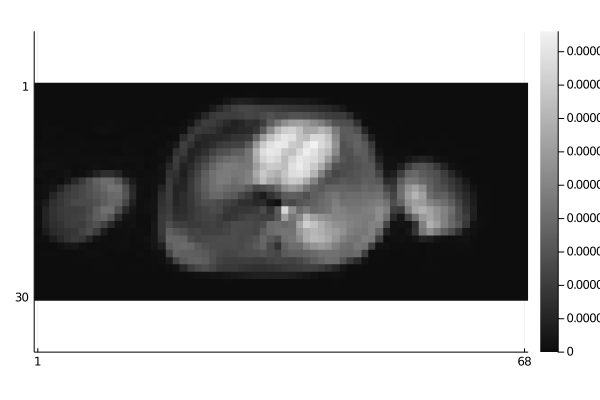

In [146]:
visualize(ℳⱼ[3] * (L_py[3] .* R_py[3][20, ..]), slice=16)

In [75]:
size(σ[1]), size(σ[2]), size(σ[3])

((8, 7, 16, 1, 1, 1), (4, 3, 8, 1, 1, 1), (2, 1, 4, 1, 1, 1))

In [82]:
r = recon.MultiScaleLowRankRecon(ksp_py, coord_py, dcf_py, mps, T, lamda, max_epoch=1,
    max_power_iter=1, device=device, blk_widths=blk_widths)


MaxEig: 100%|█████████████████| 1/1 [00:00<00:00, 120.17it/s, max_eig=1.80E+01]

PyObject <python.multi_scale_low_rank_recon.MultiScaleLowRankRecon object at 0x7f695ae88f98>

In [148]:
sp.get_device(r.sigma[1])

PyObject <CUDA Device 0>

In [83]:
r._init_vars()

In [84]:
r._power_method()


PowerIter L 1/1: 100%|███████████████████████| 100/100 [00:05<00:00, 17.40it/s]

In [92]:
σ1_py = sp.to_device(r.sigma[1], sp.cpu_device)
σ2_py = sp.to_device(r.sigma[2], sp.cpu_device)
σ3_py = sp.to_device(r.sigma[3], sp.cpu_device);

In [95]:
norm(σ1_py, 2), norm(σ[1], 2)

(0.093617536f0, 0.10104409f0)

In [96]:
norm(σ2_py, 2), norm(σ[2], 2)

(0.08588073f0, 0.09338439f0)

In [98]:
norm(σ3_py, 2), norm(σ[3], 2)

(0.05388233f0, 0.06413252f0)

In [94]:
norm(σ1_py - σ[1], Inf), norm((σ1_py - σ[1]) ./ σ1_py, Inf)

(0.0037467908f0, 3.9972491f0)

In [99]:
norm(σ2_py - σ[2], Inf), norm((σ2_py - σ[2]) ./ σ2_py, Inf)

(0.009923733f0, 3.5825138f0)

In [100]:
norm(σ3_py - σ[3], Inf), norm((σ3_py - σ[3]) ./ σ3_py, Inf)

(0.011277374f0, 1.4571968f0)